your upvotes are appreciated 🥰

your comments are considered 🧐

![RFM matric](http://d35fo82fjcw0y8.cloudfront.net/2018/03/01013508/Incontent_image.png)

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import time, warnings
import datetime as dt


from sklearn.cluster import KMeans
import plotly.express as px
import plotly.graph_objects as go
import matplotlib.pyplot as plt
from sklearn.metrics import silhouette_score

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/ecommerce-data/data.csv


# Data Loading

In [2]:
retail_df = pd.read_csv("/kaggle/input/ecommerce-data/data.csv",encoding="ISO-8859-1",dtype={'CustomerID': str,'InvoiceID': str})

retail_df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850,United Kingdom


In [3]:
retail_df['Country'].unique()

array(['United Kingdom', 'France', 'Australia', 'Netherlands', 'Germany',
       'Norway', 'EIRE', 'Switzerland', 'Spain', 'Poland', 'Portugal',
       'Italy', 'Belgium', 'Lithuania', 'Japan', 'Iceland',
       'Channel Islands', 'Denmark', 'Cyprus', 'Sweden', 'Austria',
       'Israel', 'Finland', 'Bahrain', 'Greece', 'Hong Kong', 'Singapore',
       'Lebanon', 'United Arab Emirates', 'Saudi Arabia',
       'Czech Republic', 'Canada', 'Unspecified', 'Brazil', 'USA',
       'European Community', 'Malta', 'RSA'], dtype=object)

In [4]:
retail_FR = retail_df[retail_df['Country']=='United Kingdom']
retail_FR.shape

(495478, 8)

# **Data Cleaning**

In [5]:
retail_FR = retail_FR[retail_FR['Quantity']>0] 
retail_FR.shape

(486286, 8)

In [6]:
retail_FR.dropna(subset=['CustomerID'],how='all',inplace=True)
retail_FR.shape

(354345, 8)

In [7]:
#choosing the time interval where we make the analysis for this analysis 
retail_FR = retail_FR[retail_FR['InvoiceDate']>= "2010-12-09"]
retail_FR.shape

(176137, 8)

# final Data size and desicription

In [8]:
print("Summary..")
#exploring the unique values of each attribute
print("Number of transactions: ", retail_FR['InvoiceNo'].nunique())
print("Number of products bought: ",retail_FR['StockCode'].nunique())
print("Number of customers:", retail_FR['CustomerID'].nunique() )

Summary..
Number of transactions:  8789
Number of products bought:  3294
Number of customers: 2864


# RFM Analysis
RFM (Recency, Frequency, Monetary) analysis is a customer segmentation technique that uses past purchase behavior to divide customers into groups. RFM helps divide customers into various categories or clusters to identify customers who are more likely to respond to promotions and also for future personalization services.

* RECENCY (R): Days since last purchase
* FREQUENCY (F): Total number of purchases
* MONETARY VALUE (M): Total money this customer spent.

We will create those 3 customer attributes for each customer.

# Recency
Recency is how many days ago was the customer's last purchase.

first we need to have a reference date point to count from it 

In [9]:
#last date available in our dataset
retail_FR['InvoiceDate'].max()

'9/9/2011 9:52'

In [10]:
# the last purchase happend in our table is 9/9/2011 
import time, warnings
import datetime as dt

reference_datepoint = dt.date(2011,12,9)
print(reference_datepoint)

2011-12-09


In [11]:
#create a new column called date which contains the date of invoice only
retail_FR['date'] = pd.DatetimeIndex(retail_FR['InvoiceDate']).date
retail_FR.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,date
105335,545220,21955,DOORMAT UNION JACK GUNS AND ROSES,2,3/1/2011 8:30,7.95,14620,United Kingdom,2011-03-01
105336,545220,48194,DOORMAT HEARTS,2,3/1/2011 8:30,7.95,14620,United Kingdom,2011-03-01
105337,545220,22556,PLASTERS IN TIN CIRCUS PARADE,12,3/1/2011 8:30,1.65,14620,United Kingdom,2011-03-01
105338,545220,22139,RETROSPOT TEA SET CERAMIC 11 PC,3,3/1/2011 8:30,4.95,14620,United Kingdom,2011-03-01
105339,545220,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,4,3/1/2011 8:30,3.75,14620,United Kingdom,2011-03-01


In [12]:
#group by customers and check last date of purshace
recency_df = retail_FR.groupby(by='CustomerID', as_index=False)['date'].max()
recency_df.columns = ['CustomerID','LastPurshaceDate']
recency_df.head()


,CustomerID,LastPurshaceDate
0,12747,2011-08-22
1,12748,2011-09-30
2,12749,2011-08-01
3,12820,2011-09-26
4,12821,2011-05-09


In [13]:
#calculate recency
recency_df['Recency'] = recency_df['LastPurshaceDate'].apply(lambda x: (reference_datepoint - x).days)

In [14]:
recency_df.head()
#recency_df['Recency']=(recency_df['Recency']-recency_df['Recency'].mean())/recency_df['Recency'].std()


,CustomerID,LastPurshaceDate,Recency
0,12747,2011-08-22,109
1,12748,2011-09-30,70
2,12749,2011-08-01,130
3,12820,2011-09-26,74
4,12821,2011-05-09,214


In [15]:
#recency_df.head()


In [16]:
#drop LastPurchaseDate as we don't need it anymore
recency_df.drop('LastPurshaceDate',axis=1,inplace=True)

# Frequency

how many invoices are registered by the same customer.

In [17]:
# drop duplicates
retail_FR_copy = retail_FR
retail_FR_copy.drop_duplicates(subset=['InvoiceNo', 'CustomerID'], keep="first", inplace=True)


#calculate frequency of purchases
frequency_df = retail_FR_copy.groupby(by=['CustomerID'], as_index=False)['InvoiceNo'].count()
frequency_df.columns = ['CustomerID','Frequency']
frequency_df.head()

,CustomerID,Frequency
0,12747,5
1,12748,96
2,12749,3
3,12820,1
4,12821,1


In [18]:
#frequency_df['Frequency']=(frequency_df['Frequency']-frequency_df['Frequency'].mean())/frequency_df['Frequency'].std()
#frequency_df.head()

# Monetary
How much money did the customer spent over time?

In [19]:
#create column total cost
retail_FR['TotalCost'] = retail_FR['Quantity'] * retail_FR['UnitPrice']

In [20]:
monetary_df = retail_FR.groupby(by='CustomerID',as_index=False).agg({'TotalCost': 'sum'})
monetary_df.columns = ['CustomerID','Monetary']
monetary_df.head()

,CustomerID,Monetary
0,12747,191.85
1,12748,1054.43
2,12749,67.00
3,12820,15.00
4,12821,19.92


In [21]:
#monetary_df['Monetary']=(monetary_df['Monetary']-monetary_df['Monetary'].mean())/monetary_df['Monetary'].std()
#monetary_df.head()

In [22]:
#merge recency dataframe with frequency dataframe
temp_df = recency_df.merge(frequency_df,on='CustomerID')
#merge with monetary dataframe to get a table with the 3 columns
rfm_df = temp_df.merge(monetary_df,on='CustomerID')
#use CustomerID as index
rfm_df.set_index('CustomerID',inplace=True)
#check the head
rfm_df.head()

,Recency,Frequency,Monetary
CustomerID,,,
12747,109,5,191.85
12748,70,96,1054.43
12749,130,3,67.00
12820,74,1,15.00
12821,214,1,19.92


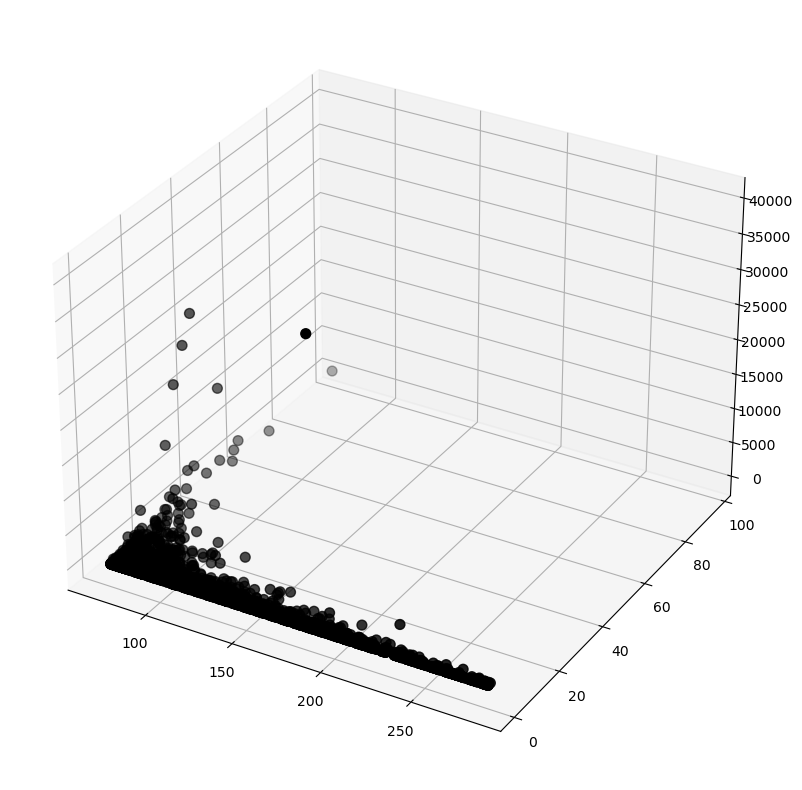

In [23]:
plt.figure(figsize = (20,10))
ax = plt.axes(projection='3d')
fg = ax.scatter3D(rfm_df['Recency'],rfm_df['Frequency'],rfm_df['Monetary'],s = 50, c = 'black')

# Skewed data😖

Skewed data is very common, it might also skew our results thats why we have to change that. 
The very popular and easy solution is to transform the data using **log transform**

In [24]:
# transforming each colum in RFM 
rfm_df['Recency'] = np.log(rfm_df['Recency'])
rfm_df['Frequency'] = np.log(rfm_df['Frequency'])
rfm_df['Monetary'] = np.log(rfm_df['Monetary'])


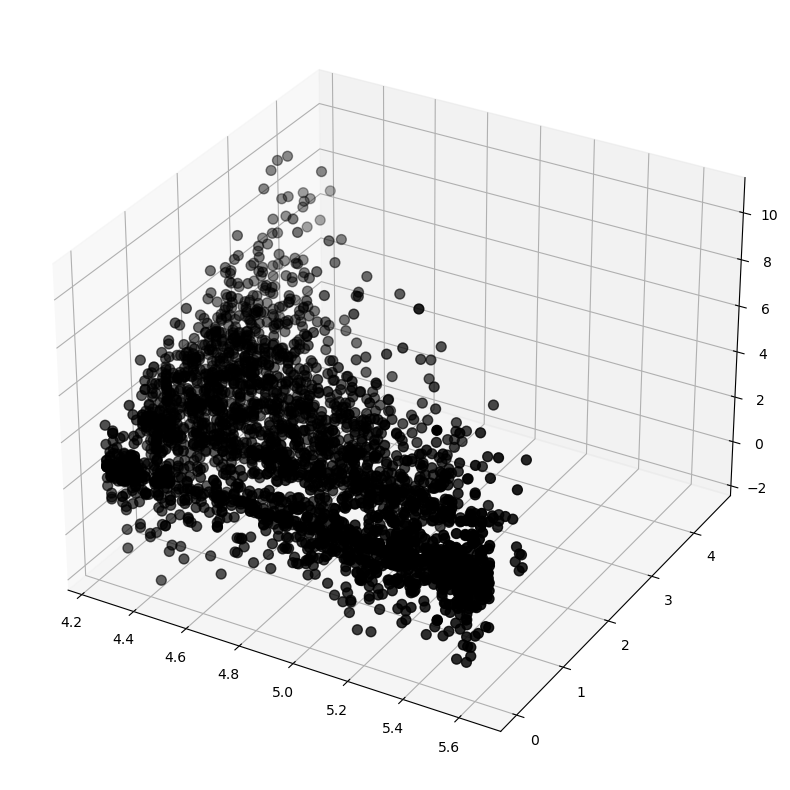

In [25]:
# plotting the transformed data 
plt.figure(figsize = (20,10))
ax = plt.axes(projection='3d')
fg = ax.scatter3D(rfm_df['Recency'],rfm_df['Frequency'],rfm_df['Monetary'],s = 50, c = 'black')

# Unsupervised Learning 

now since we prepared the dataset into RFM format 

there is statistical methods to segment the customers but we will use unsupervised learining algorithms ,we will try 
* DB scan 
* K-means 

![](https://miro.medium.com/v2/resize:fit:1400/format:webp/1*KqWII7sFp1JL0EXwJGpqFw.png)

# K-means with elbow method

/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:8

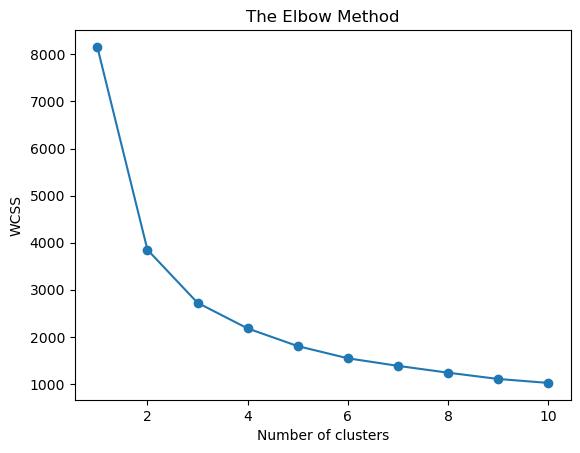

In [26]:
#using the elbow method to test multiple choices for the k 
wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters = i, init = 'k-means++', random_state = 42)
    kmeans.fit(rfm_df)
    wcss.append(kmeans.inertia_)
plt.plot(range(1, 11), wcss, marker = 'o')
plt.title('The Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()


In [27]:
kmeans = KMeans(n_clusters = 3, init = 'k-means++', random_state = 42)
y_kmeans = kmeans.fit_predict(rfm_df)

/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [28]:
rfm_df

,Recency,Frequency,Monetary
CustomerID,,,
12747,4.691348,1.609438,5.256714
12748,4.248495,4.564348,6.960756
12749,4.867534,1.098612,4.204693
12820,4.304065,0.000000,2.708050
12821,5.365976,0.000000,2.991724
...,...,...,...
18280,5.624018,0.000000,3.165475
18281,5.192957,0.000000,1.617406
18282,4.836282,0.000000,2.545531


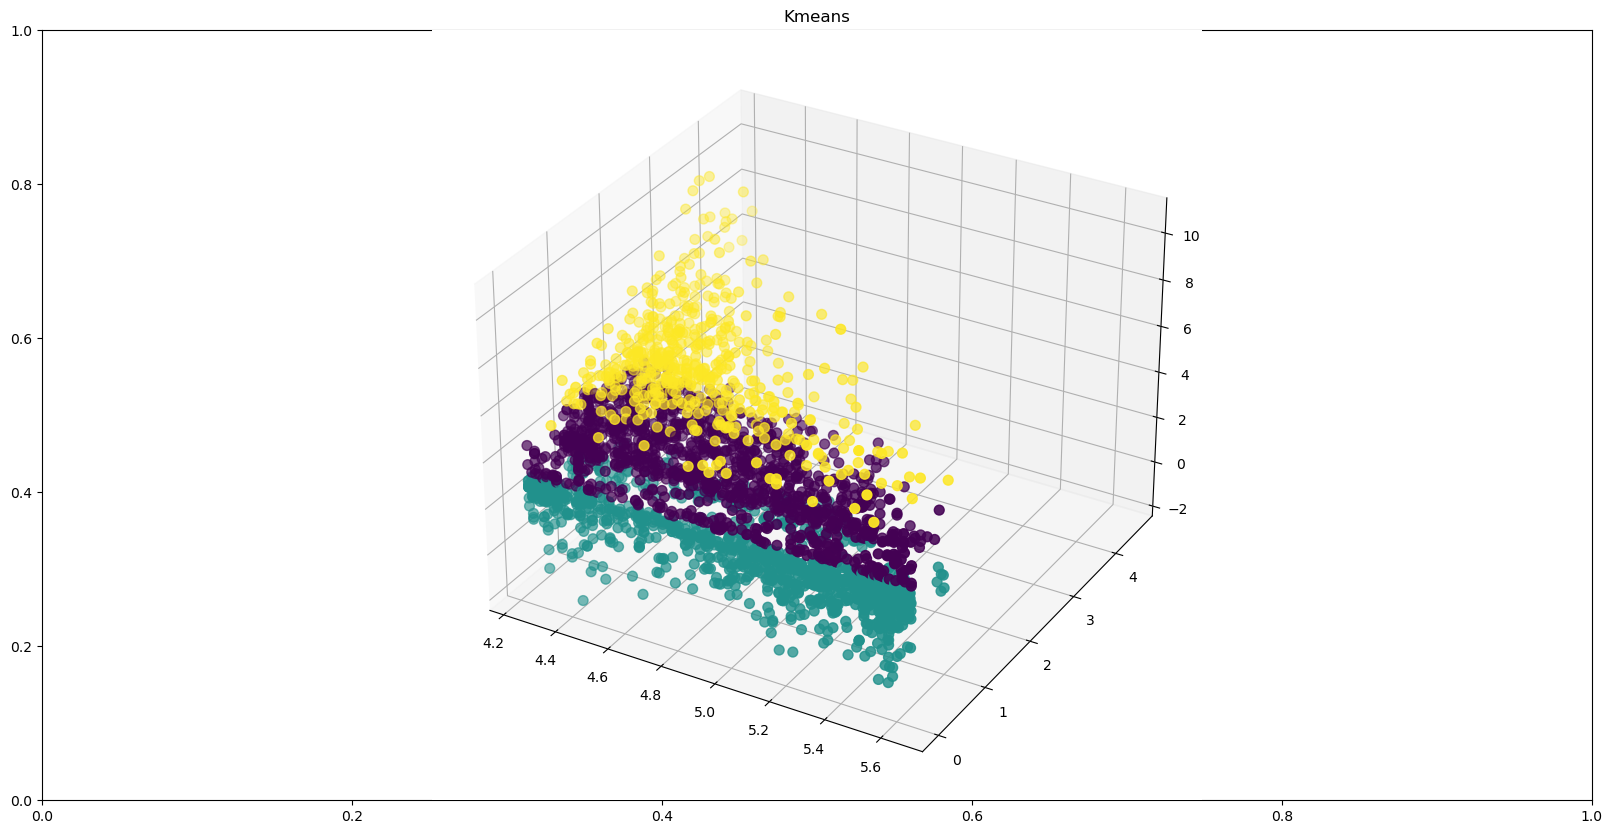

In [29]:
plt.figure(figsize = (20,10))
plt.title("Kmeans")
ax = plt.axes(projection='3d')
fg = ax.scatter3D(rfm_df['Recency'],rfm_df['Frequency'],rfm_df['Monetary'],s = 50, c = y_kmeans,)

In [30]:
silhouette_avg = silhouette_score(rfm_df,y_kmeans)
print("For n_clusters =", 3 ,"The average silhouette_score is :",silhouette_avg)

For n_clusters = 3 The average silhouette_score is : 0.361643715192203


# using k-means with pca to plot in 2 d 

/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


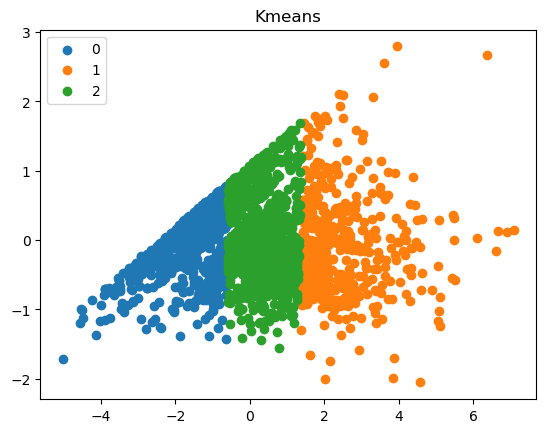

In [31]:
#Importing required modules
 
from sklearn.decomposition import PCA
import numpy as np
 
pca = PCA(2)
 
#Transform the data
df = pca.fit_transform(rfm_df)
 
#Import KMeans module
from sklearn.cluster import KMeans
 
#Initialize the class object
kmeans = KMeans(n_clusters= 3)
 
#predict the labels of clusters.
label = kmeans.fit_predict(df)
 
#Getting unique labels
u_labels = np.unique(label)
 
#plotting the results:
for i in u_labels:
    plt.scatter(df[label == i , 0] , df[label == i , 1] , label = i)
plt.legend()
plt.title("Kmeans")
plt.show()

In [32]:
# for the 2d data
silhouette_avg = silhouette_score(df,label)
print("For n_clusters =", 3 ,"The average silhouette_score is :",silhouette_avg)

For n_clusters = 3 The average silhouette_score is : 0.40657082279647494


In [33]:
from sklearn.cluster import DBSCAN

# remember to put .drop(columns='y_DBscan') if you decided to run this cell again or your results well be wrong 
rfm_df['y_DBscan'] = DBSCAN(eps=0.5, min_samples=100).fit_predict(rfm_df)

#the dbscan label the outlayers with -1 class ,so we trancite the -1 class next 
rfm_df = rfm_df[rfm_df['y_DBscan']>= 0]


# evaluation metric
silhouette_avg = silhouette_score(rfm_df.drop(columns='y_DBscan'),rfm_df['y_DBscan'])
print("For eps =", 0.5 ,"For min_samples =", 100 ,"The average silhouette_score is :",silhouette_avg)


For eps = 0.5 For min_samples = 100 The average silhouette_score is : 0.4080775763736231


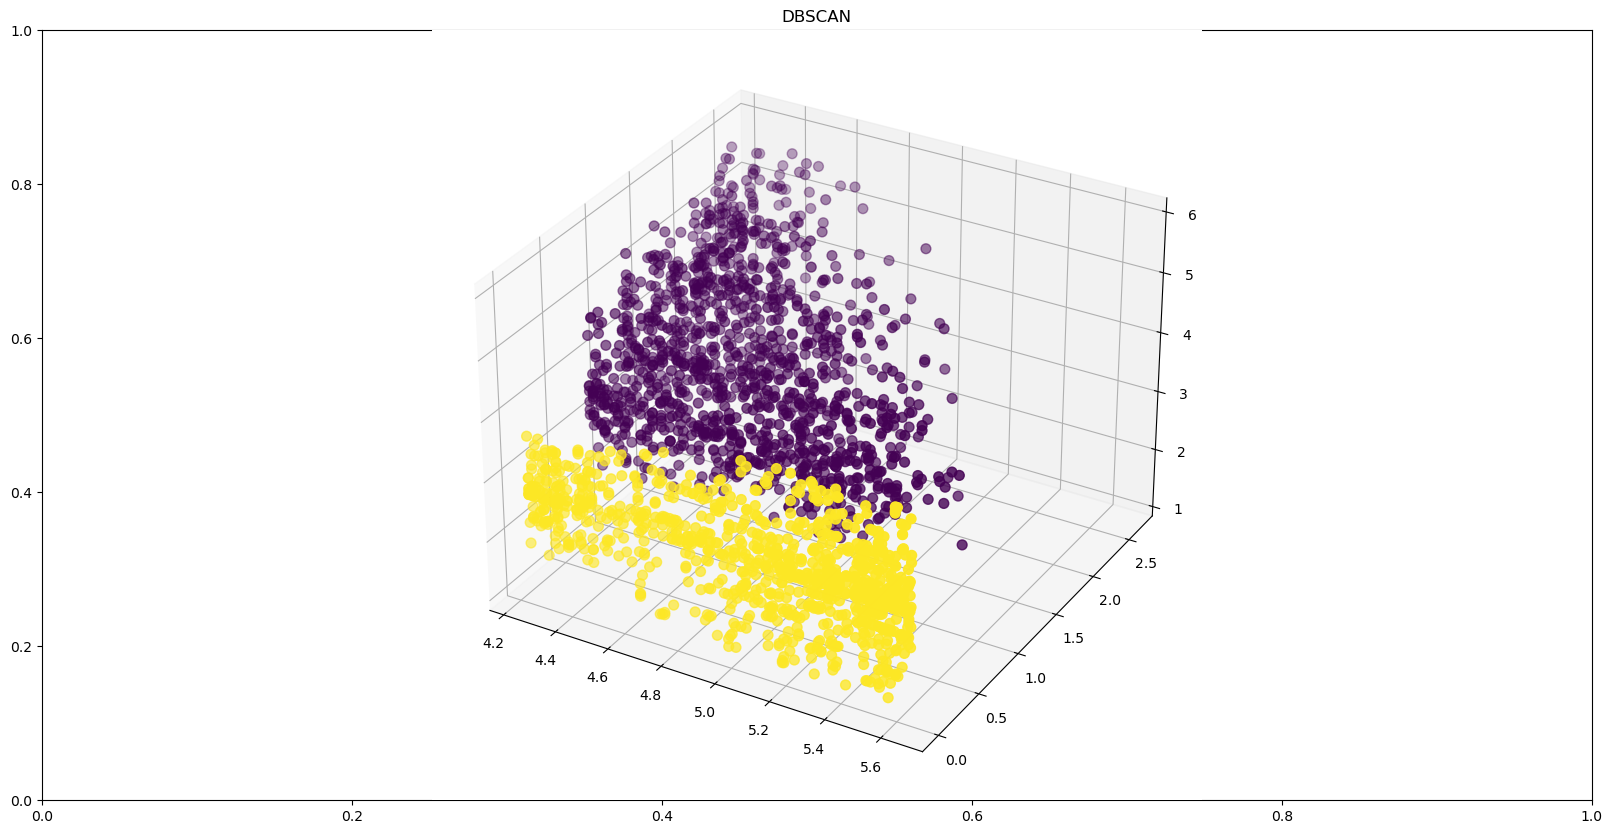

In [34]:
plt.figure(figsize = (20,10))
plt.title("DBSCAN")
ax = plt.axes(projection='3d')
fg = ax.scatter3D(rfm_df['Recency'],rfm_df['Frequency'],rfm_df['Monetary'],s = 50, c = rfm_df['y_DBscan'],)

In [35]:
# remember we deleted the -1 class so every time we change the hyberparamters the size of our dataset change too

print(rfm_df['y_DBscan'].unique(),rfm_df.shape)

rfm_df['y_DBscan'].value_counts()


[0 1] (2309, 4)


0    1302
1    1007
Name: y_DBscan, dtype: int64

my commentary

I tried k-means and dbscans from previous projects i used k-means alot for similiar problems and bdscan too 

I used silhouette_score to compare between the two models as they both have similar clusters in plots 
i tried diffrent numbers in both k for kmeans and eps, min_samples for dbscan, the kmeans doesnt get higher than 0.38(with pca it reachs 0.41 however with pca the meaning of rfm vanish thats why i am not consider it) and the dbscan doesnt get higher than 0.40 so the dbscan win 

we would still need to cluster them into best customers ,loyal customer ,lost customers for deision making and custom pormotions and offers 
